In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytz 
from scipy.optimize import minimize 
import generate_data
import economic_analysis
import optimization
from importlib import reload 
import pandas as pd
import json
import os 

### <font color  = 'orange'> To-Do:
Check out results for with brendan's data </br>
(for with michael or Thinus) Calculate battery degradation in terms of number of cycles?? Look at what they did in that one paper with several diff batteries.
<font>

## Generate Data

### Simulate charging load and insolation profiles

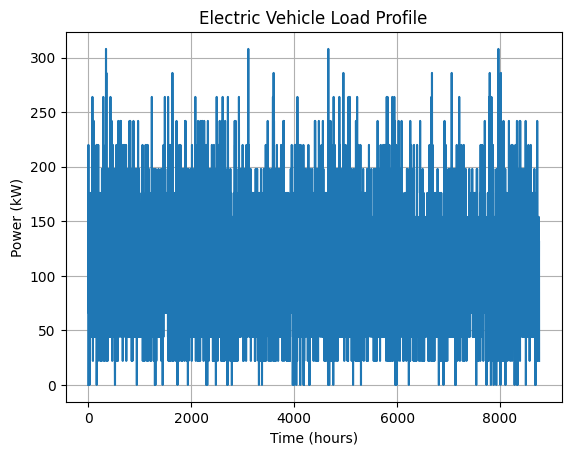

In [2]:
total_days = 365  # Total number of days to simulate
total_time = 24 * total_days  # Total simulation time in hours
time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
num_vehicles = 47  # Number of EVs in the simulation
charging_power = 22  # Charging power in kW (e.g., Level 2 charging)
load_profile_simulated = generate_data.simulate_charging_load_profile(total_days, total_time,time_resolution, num_vehicles, charging_power)

In [3]:
# Generate equivalent ICE vehicle cost based on kWh utilization
vehicle_kWh_km = 0.2 # kWh/km
vehicle_km_per_year = load_profile_simulated.sum() * vehicle_kWh_km
fuel_cost = 1.5 # $/L
fuel_economy = 6.0 # L/100km
ICE_fuel_cost_per_year = fuel_cost * fuel_economy * vehicle_km_per_year / 100 



#### Getting charging profile from Jacques data

In [4]:
class chargingStation:
    def __init__(self):
        self.charging_power = 7
        self.charging_efficiency = 0.95
        self.discharging_efficiency = 0.95
        self.battery_capacity = 40
        self.battery_duration = 6
        

def retrieve_all_vehicle_data(df_data):
    keys = ['time', 'duration', 'end_point', 'end_soc', 'soc_per_min', 'mode', 'distance', 'start_point', 'trip_num', 'lateness']

    # Use list comprehensions to extract values for each key and handle missing keys with np.nan
    values = [[item.get(key, np.nan) for key in keys] for item in df_data]

    # Create the DataFrame using the zipped lists
    df = pd.DataFrame(values, columns=keys)
    return df




def get_charging_profile(df):
    df = df[1:]
    df['soc_per_min'] = np.where(df['mode'] != 'charging', 0, df['soc_per_min'])
    
    # Create an empty dataframe with 1440 rows and a 'kWh_charged' column
    df_minute = pd.DataFrame({'kWh_charged': np.nan}, index=range(1440))

    # Iterate over each row in the original dataframe
    for _, row in df.iterrows():
        
        start_minute = int(row['time'])  # Starting minute of charging
        end_minute = start_minute + int(row['duration'])  # Ending minute of charging
    
        # Assign the 'soc_per_min' value to the corresponding minutes in the new dataframe
        df_minute.loc[start_minute:end_minute, 'kWh_charged'] = row['soc_per_min']

    # Fill any remaining NaN values with 0
    df_minute.fillna(0, inplace=True)

    return df_minute


def get_cumulative_charging_profile(vehicle_data):
    
    vehicle_charging_profiles = {}
    for key in vehicle_data:
        vehicle_charging_profiles[key] = get_charging_profile(vehicle_data[key])
        
    #plt.plot(vehicle_charging_profiles[key]['kWh_charged'], label=key)

    # Get cumulative charging profile for all vehicles
    charging_profile = pd.DataFrame({'kWh_charged': np.zeros(1440)}, index=range(1440))
    for key in vehicle_charging_profiles:
        charging_profile['kWh_charged'] += vehicle_charging_profiles[key]['kWh_charged']
        
    # plt.plot(charging_profile['kWh_charged'], label='Cumulative load from all vehicles')
    # plt.legend()
    # plt.xlabel('Minute of Day')
    # plt.ylabel('kWh Charged')
    # plt.show()
        
    return charging_profile 

def read_json(filepath):
    f = open(filepath)
    data = json.load(f)
    f.close()
    return data


def process_charging_profile(json_path, title, save_filename):
    data = read_json(json_path)
    vehicle_data = {key: retrieve_all_vehicle_data(data[key]) for key in data}
    charging_profile = get_cumulative_charging_profile(vehicle_data)
    
    # plt.plot(charging_profile)
    # plt.title(title)
    # plt.legend()
    # plt.ylabel('kWh charged')
    # plt.xlabel('Minute of the day')
    # plt.savefig(save_filename)
    # plt.show()
    return charging_profile 


/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_839/3102591522.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soc_per_min'] = np.where(df['mode'] != 'charging', 0, df['soc_per_min'])


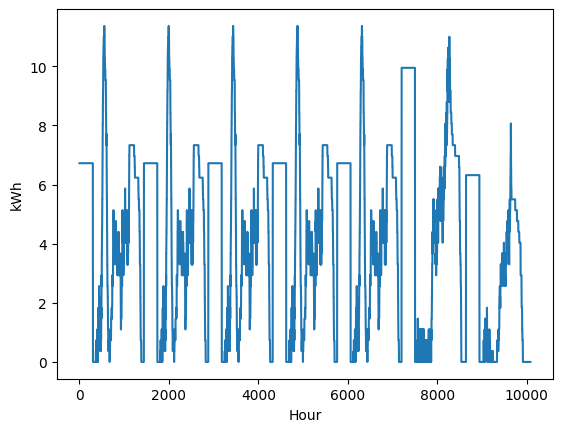

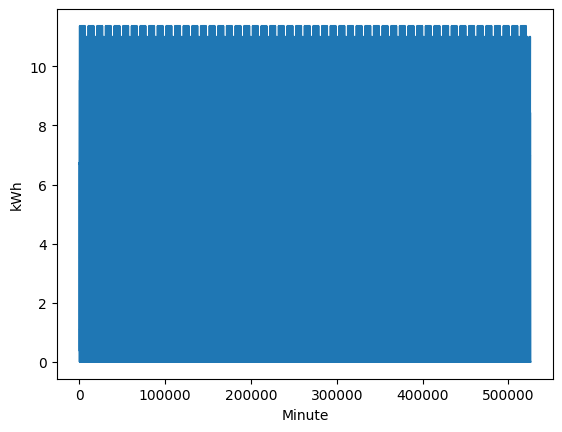

In [5]:
START_OF_OPERATIONS = 300 # 5am

# Process Monday to Friday charging profile
mon_fri_json_path = 'data/mon_to_fri_440.json'
mon_fri_title = 'Mon-Fri Charging Profile'
mon_fri_save_filename = 'mon_fri_charge_profile.png'
mon_fri_charging_profile = process_charging_profile(mon_fri_json_path, mon_fri_title, mon_fri_save_filename)

# Charging before 5am  is 0 (assume charge at home because that's where they park - or readjust when Jacques readjusts)
# stretch the charging done between 0 and 110 to be done between 0 and 300 
mon_fri_charging_profile[0:300] = mon_fri_charging_profile.iloc[0] * np.argmax(mon_fri_charging_profile == 0)/START_OF_OPERATIONS

weekly_charging_profile = pd.concat([mon_fri_charging_profile]*5, ignore_index=True)

# Process Saturday charging profile
sat_json_path = 'data/sat_686.json'
sat_title = 'Sat Charging Profile'
sat_save_filename = 'sat_charge_profile.png'
sat_charging_profile = process_charging_profile(sat_json_path, sat_title, sat_save_filename)
# stretch the charging done between 0 and 110 to be done between 0 and 300 
sat_charging_profile[0:300] = sat_charging_profile.iloc[0] * np.argmax(sat_charging_profile == 0)/START_OF_OPERATIONS

# Process Sunday charging profile
sun_json_path = 'data/sun_420.json'
sun_title = 'Sun Charging Profile'
sun_save_filename = 'sun_charge_profile.png'
sun_charging_profile = process_charging_profile(sun_json_path, sun_title, sun_save_filename)
sun_charging_profile[0:300] = sun_charging_profile.iloc[0] * np.argmax(sun_charging_profile == 0)/START_OF_OPERATIONS

# Get a full week charging profile 
charging_profile = pd.concat([weekly_charging_profile, sat_charging_profile, sun_charging_profile], ignore_index = True)
# Downsample to hourly resolution 
plt.plot(charging_profile)
plt.xlabel("Hour")
plt.ylabel("kWh")
plt.savefig("figures/charging_profile.png")
plt.show()

# Get a yearly version of the charging profile
charging_profile_year = pd.concat([charging_profile]*52, ignore_index=True)
charging_profile_year = pd.concat([charging_profile_year, sat_charging_profile], ignore_index=True) #add another day to reach 365 days (52 weeks + 1 day)
plt.plot(charging_profile_year)
plt.xlabel("Minute")
plt.ylabel('kWh')
plt.show()



Downsample from minutely to hourly

This must be 8760:  8760


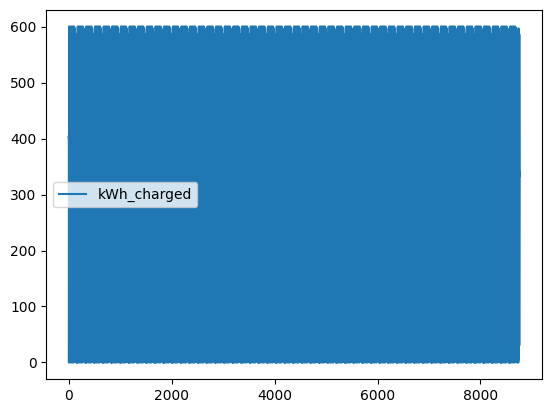

In [6]:
# Select every 60th row using array indexing
hourly_charging_profile = charging_profile_year.rolling(window=60).sum().iloc[::60]

# Reset the index to RangeIndex if desired
hourly_charging_profile.reset_index(drop=True, inplace=True)

hourly_charging_profile.plot()
load_profile_optimized = hourly_charging_profile['kWh_charged'].values
# fill NaN values with 0
load_profile_optimized = np.nan_to_num(load_profile_optimized)
print("This must be 8760: ", len(load_profile_optimized))

#### Get charge profile from Brendan data (Stellenbosch fleet)

In [122]:
# initialize path
path = "../SCE_22kW_N6_B70_HC_False"

# initialize dictionary to hold grid power data for each day
all_grid_power_data = {}

# loop through each folder with prefix "Day" in path
for folder in os.listdir(path):
    # check if folder name contains "Day"
    if "Day" in folder:
        # only consider folders that are not files
        if "." not in folder:
            # read in grid_power.csv
            grid_power = pd.read_csv(os.path.join(path, folder, "grid_power.csv"))
            #rowsum 
            total_watts_per_sec = grid_power.sum(axis=1) / 3.6e6 # Divide by 3.6e6 to go from Ws to kWh (now we have kWh/second)
            # Get the kWh draw per hour 
            kwh_per_hour = total_watts_per_sec.groupby(total_watts_per_sec.index // 3600).sum() # kWh/second to kWh/hour 
            # save to dict
            all_grid_power_data[folder] = kwh_per_hour
            
            

 


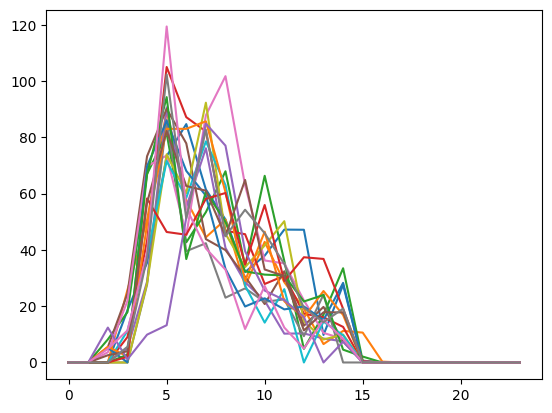

In [237]:
for k, df in all_grid_power_data.items():
    plt.plot(df)

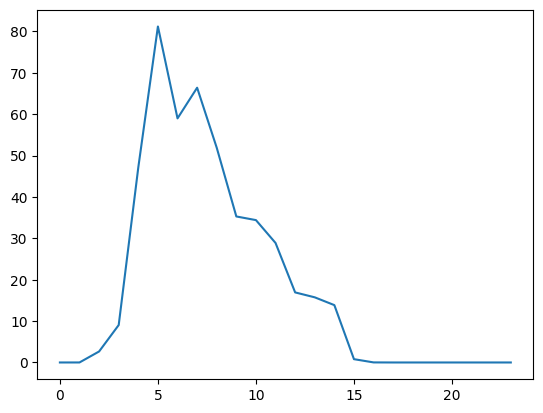

In [124]:
# sum the values in all of the dataframes in all_grid_power_data
# and save the results in a new dataframe called all_grid_power_data_summed
all_grid_power_data_summed = pd.DataFrame(index = range(0,25), columns = ['summed_power'])
all_grid_power_data_summed['summed_power'] = [0] * 25

for day, data in all_grid_power_data.items():
    all_grid_power_data_summed['summed_power'] += data # add the data for each day to the dataframe
    
average_pwr_draw = all_grid_power_data_summed['summed_power']/len(all_grid_power_data) # divide by the number of days to get the average
plt.plot(average_pwr_draw)
load_profile_brendan = average_pwr_draw

#### Solar profile

Pysolar (deprecated)

/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: overflow encountered in exp
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime
/Users/Orie4416/Desktop/Feasibility Assessment/chullenv/lib/python3.9/site-packages/pysolar/radiation.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime


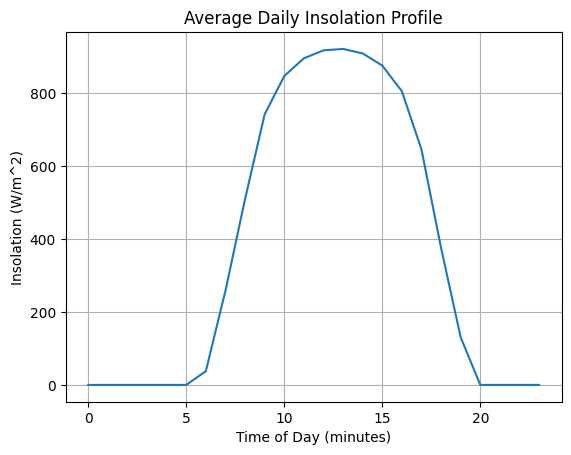

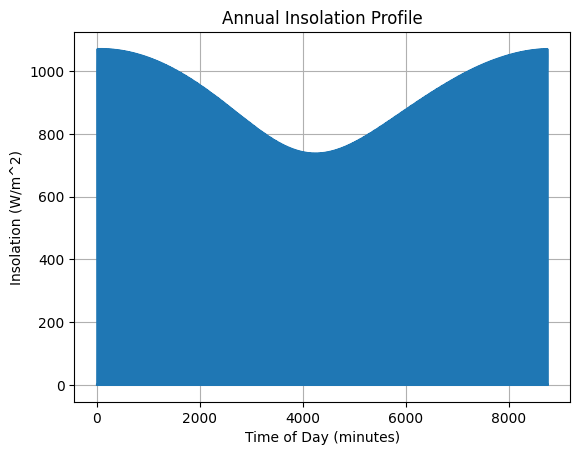

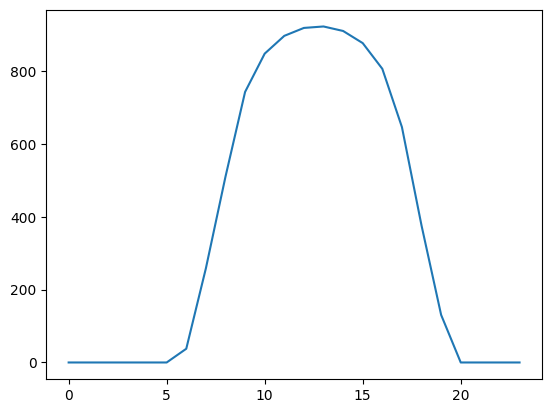

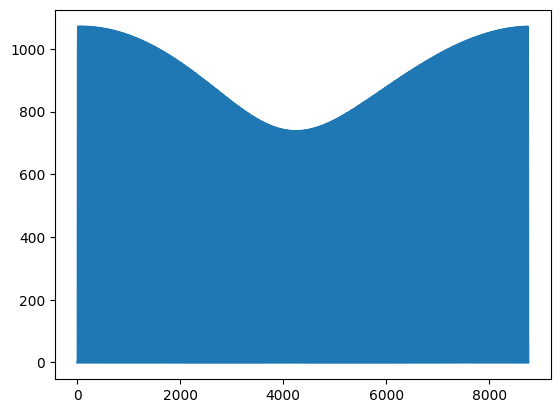

In [20]:
# Location coordinates (latitude, longitude)
latitude = -33.9321  # Stellenbosch, SA
longitude = 18.8602

# Time resolution in minutes
time_resolution = 60

# Set the time zone
timezone = pytz.timezone('Africa/Cairo')  
daily_insolation_profile, annual_insolation_profile = generate_data.simulate_insolation_profile(latitude, longitude, time_resolution, timezone)
# # Save profiles 
pd.DataFrame(daily_insolation_profile).to_csv(f'solar_profiles/daily_insolation_profile_{time_resolution}_min_res.csv')
pd.DataFrame(annual_insolation_profile).to_csv(f'solar_profiles/annual_insolation_profile_{time_resolution}_min_res.csv')
daily_insolation_profile = pd.read_csv(f'solar_profiles/daily_insolation_profile_{time_resolution}_min_res.csv', index_col = 0)
annual_insolation_profile = pd.read_csv(f'solar_profiles/annual_insolation_profile_{time_resolution}_min_res.csv', index_col = 0)
# debug daily_insolation_profile = pd.read_csv(f'daily_insolation_profile_{time_resolution}_min_res.csv', index_col=0)
# debug annual_insolation_profile = pd.read_csv(f'annual_insolation_profile_{time_resolution}_min_res.csv', index_col=0)
daily_insolation_profile = daily_insolation_profile.values.flatten()
annual_insolation_profile = annual_insolation_profile.values.flatten()

plt.plot(daily_insolation_profile)
plt.show()
plt.plot(annual_insolation_profile)
plt.show()



Renewables.ninja

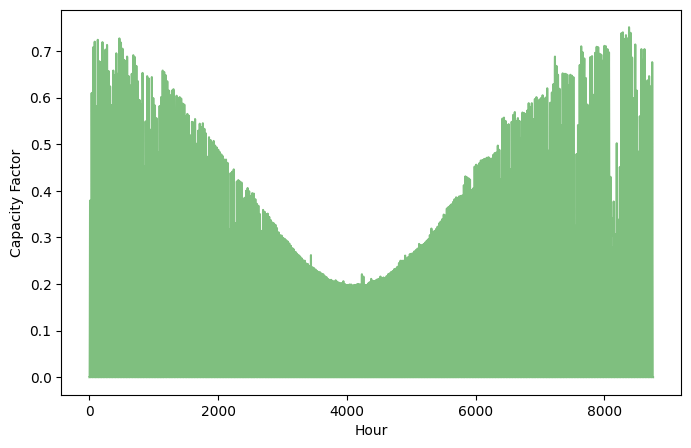

In [7]:
# Read starting from line 4
annual_capacity_factor = pd.read_csv("solar_profiles/renewables_ninja_profile.csv", skiprows=3)
annual_capacity_factor = annual_capacity_factor['electricity'].values
plt.plot(annual_capacity_factor, color = 'green', alpha = 0.5)
plt.ylabel('Capacity Factor')
plt.xlabel('Hour')
# Make graph wider
plt.gcf().set_size_inches(8, 5)

plt.savefig('solar_profiles/renewables_ninja_profile.png')
plt.show()


### Define input parameters

In [8]:
rand_to_usd = 1/16.66


Solar PV 

In [9]:
# Solar PV cost
panel_wattage = 415 # Rand
cost_per_panel = 2633.35 # Rand
cost_per_watt = cost_per_panel / panel_wattage
cost_per_watt_usd = cost_per_watt * rand_to_usd
pv_cost_per_kw = cost_per_watt_usd * 1000 # $/kW

# Inverter 
inverter_cost = 1.00 # R / kW 
inverter_cost = inverter_cost * rand_to_usd # $/kW 

inverter_cost_schedule = {2000: 7635.66,
                          5000: 13957.40,
                          8000: 18000.00, 
                          25000: 39695.29,
                          80000: 63184.85}

# convert all values in inverter cost schedule to usd
inverter_cost_schedule = {key: value * rand_to_usd for key, value in inverter_cost_schedule.items()}


# Components cost
component_cost = inverter_cost + pv_cost_per_kw # $/kW

# Other costs
peripherals_cost = component_cost * 0.20 # $/kW
installation_cost = (component_cost + peripherals_cost) * 0.10 # $/kW
markup_cost = (component_cost + peripherals_cost + installation_cost) * 0.33 # $/kW

# Total capital cost
total_cost = component_cost + peripherals_cost + installation_cost + markup_cost # $/kW

# Maintenance cost 
pv_annual_maintenance_cost = 500 * rand_to_usd #$

# PV system specifications
pv_efficiency = 0.90  # 85% efficiency
pv_m_sq_per_kw = 2/0.465 # m^2/kW
Rproj = 20 # project lifetime (yrs)
solar_annual_degradation = 0.006 # 0.6% degradation per year

# Residual value
solar_residual_value_factor = 0.10 # %

Battery

In [82]:
# Battery cost
battery_size = 2400 #Wh
cost_per_battery = 12308.12 # Rand
battery_cost_per_wh = cost_per_battery/battery_size
# convert to usd
battery_cost_per_kwh = battery_cost_per_wh * rand_to_usd * 1000  # $/kWh 

battery_annual_maintenance = 500 * rand_to_usd # $/year

# Battery system specifications
battery_charging_efficiency = np.sqrt(0.95) #%
battery_discharging_efficiency = np.sqrt(0.95) #% 
battery_annual_degradation = 0.025 # % per year
battery_duration = 4 # hours (for max power draw
battery_depth_of_discharge = 0.90 # %

# Residual value
battery_residual_value_factor = 0.1 # % of initial cost

Grid energy costs and schedule

In [12]:
# Energy costs and schedule 

time_of_use_tariffs = {'peak': 6.97 * rand_to_usd,
                       'standard': 2.46 * rand_to_usd,
                       'off_peak': 1.57 * rand_to_usd}
time_periods = {'peak_hours': [7,8,9,18,19],
                'standard_hours': [6,10,11,12,13,14,15,16,17,20,21],
                'off_peak_hours': [0,1,2,3,4,5,23]}

# Energy market inputs
feed_in_tariff = 0.041 # $/kWh

Compute average grid price ($/kWh) faced by vehicles

In [38]:
for hour, kwh in enumerate(charging_profile['kWh_charged']):
    print(hour,kwh)

0 6.722222222222226
1 6.722222222222226
2 6.722222222222226
3 6.722222222222226
4 6.722222222222226
5 6.722222222222226
6 6.722222222222226
7 6.722222222222226
8 6.722222222222226
9 6.722222222222226
10 6.722222222222226
11 6.722222222222226
12 6.722222222222226
13 6.722222222222226
14 6.722222222222226
15 6.722222222222226
16 6.722222222222226
17 6.722222222222226
18 6.722222222222226
19 6.722222222222226
20 6.722222222222226
21 6.722222222222226
22 6.722222222222226
23 6.722222222222226
24 6.722222222222226
25 6.722222222222226
26 6.722222222222226
27 6.722222222222226
28 6.722222222222226
29 6.722222222222226
30 6.722222222222226
31 6.722222222222226
32 6.722222222222226
33 6.722222222222226
34 6.722222222222226
35 6.722222222222226
36 6.722222222222226
37 6.722222222222226
38 6.722222222222226
39 6.722222222222226
40 6.722222222222226
41 6.722222222222226
42 6.722222222222226
43 6.722222222222226
44 6.722222222222226
45 6.722222222222226
46 6.722222222222226
47 6.722222222222226
48

In [41]:
cost = 0
for hour, kwh in enumerate(charging_profile['kWh_charged']):
    if (hour % 168) > 120: # weekend
        cost += kwh * time_of_use_tariffs['off_peak']
        
    elif (hour % 24) in time_periods['peak_hours']:
        cost += kwh * time_of_use_tariffs['peak']
        
    elif (hour % 24) in time_periods['standard_hours']:
        cost += kwh * time_of_use_tariffs['standard']
        
    else:
        cost += kwh * time_of_use_tariffs['off_peak']
cost/charging_profile['kWh_charged'].sum()

0.16043222703546764

Economic inputs 

In [85]:

# Financial market inputs
i_no = 0.15 # nominal interest rate
inflation_rate = 0.0704 # inflation rate
discount_rate = 0.05 # discount rate

# Financing terms
loan_upfront_adjustment = 0.50 # 30% of capital cost paid upfront
loan_payback_period = 20 # 10 years for the solar PV system provider to fully recoup their costs
loan_interest_rate = 0.05

pays_capital_adjustment = 0.30 # 30% of capital cost paid upfront
pays_payback_period = 20 # 10 years for the solar PV system provider to fully recoup their costs
pays_interest_rate = 0.05 # 5% annual interest rate
pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider


Environmental parameters

In [14]:
# Environmental inputs
grid_carbon_intensity = 0.95 # kgCO2/kWh
carbon_price = 50/1000 # $/kgCo2

Operational ICE inputs

In [21]:
# Taxi market inputs
cost_per_passenger = 0.50 # $/passenger

# Values of kWh in terms of passengers for different time periods 
time_passenger_per_kWh = {'morning': 0.25, 
                          'afternoon': 0.125,
                          'evening': 0.25, 
                          'night': 0.05}

# ICE vehicle specs
kwh_km = 0.70 # kWh/km
km_L = 1/0.15 # km/L
kwh_L = kwh_km * km_L # kWh/L





kwh_L

4.666666666666667

In [86]:


# Station constraints
max_land_area = 300 # m^2

# System specifications
loadshedding_probability = 3776 / 8760


##### LOAD PROFILE
# load_profile = WB_yearly_data
#load_profile = load_profile_simulated
load_profile = load_profile_optimized
# load_profile = load_profile_brendan

#### ICE VEHICLE USAGE ESTIMATES
vehicle_kWh_km = 0.20 # kWh/km
vehicle_km_per_year = vehicle_kWh_km * sum(load_profile)

a = {
    # Solar PV Profile 
    'annual_insolation_profile': annual_insolation_profile,
    'annual_capacity_factor': annual_capacity_factor,
    # EV charging load 
    'load_profile': load_profile,
    # PV costs 
    'pv_cost_per_kw': pv_cost_per_kw,
    'inverter_cost_schedule': inverter_cost_schedule,
    'pv_annual_maintenance_cost': pv_annual_maintenance_cost,
    'solar_residual_value_factor': solar_residual_value_factor,
    
    
    # PV specifications
    'Rproj': Rproj,
    'pv_efficiency': pv_efficiency,
    'solar_annual_degradation': solar_annual_degradation,# 0.6% per year

    # Battery costs
    'battery_cost_per_kWh': battery_cost_per_kwh,
    'battery_annual_maintenance_cost': battery_annual_maintenance,
    'battery_residual_value_factor': battery_residual_value_factor,
    'depth_of_discharge': battery_depth_of_discharge,
    
    # Battery specs
    'battery_charging_efficiency': battery_charging_efficiency,
    'battery_discharging_efficiency': battery_discharging_efficiency,
    'battery_annual_degradation': battery_annual_degradation, # 2% per year
    'battery_duration': battery_duration, 
    
    # Energy costs and schedule 
    'time_of_use_tariffs': time_of_use_tariffs,
    'time_periods': time_periods,
    'feed_in_tariff': feed_in_tariff,
    # Market inputs 
    'i_no': i_no,
    'f': inflation_rate,
    'discount_rate': discount_rate,
    # Environmental inputs 
    'grid_carbon_intensity': grid_carbon_intensity,
    'carbon_price': carbon_price,
    # Load shedding and operational cost of serving demand during load shedding  
    'loadshedding_probability': loadshedding_probability,
    'time_passenger_per_kWh': time_passenger_per_kWh,
    'cost_per_passenger': cost_per_passenger,
    
    # Loan model
    'loan_upfront_adjustment': loan_upfront_adjustment,
    'loan_payback_period': loan_payback_period,
    'loan_interest_rate': loan_interest_rate,
    # PAYS model
    'PAYS_capital_cost_adjustment': pays_capital_adjustment,
    'PAYS_payback_period': pays_payback_period,
    'PAYS_cut_of_savings': pays_cut_of_savings,
    'PAYS_interest_rate': pays_interest_rate,
    # Sensitivity analysis bools
    'feed_in_tariff_bool': False,
    'renewables_ninja': True,
    'carbon_price_bool': False,
    'load_shedding_bool': False,
    
    # Land area 
    'pv_m_sq_per_kw': pv_m_sq_per_kw,
    'max_land_area' : max_land_area,
}

In [35]:
# # Decision variables - PV capacity and Battery capacity 
# pv_capacity = optimal_pv_capacity
# battery_capacity = optimal_battery_capacity

# # Capital Cost of Investment 
# pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity   # (int) capital cost of PV system 
# battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
# total_capital_cost = pv_capital_cost + battery_capital_cost

# # Residual value
# residual_value = a['residual_value_factor'] * total_capital_cost

# # Generate PV Output profile 
# pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], a['annual_insolation_profile'], a['pv_efficiency'], a['renewables_ninja'], pv_capacity) 

# # Generate load shedding schedule 
# loadshedding_schedule = generate_data.generate_loadshedding_schedule(pv_output_profile,0.20)


## Optimization Model

### <font color = 'orange'> Base level optimization [this works don't touch it for now] (DEPRECATED USE DEGRADATION AS BASE ONE) <font>

In [87]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [20, 20]

a['load_profile'] = load_profile * 0.10

# Max land area constraint 
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV power rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery energy capacity: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format((a['battery_cost_per_kWh'] * optimal_battery_capacity) + economic_analysis.calculate_pv_capital_cost(optimal_pv_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(-max_npv))


Optimal PV power rating: 55.57 kW
Optimal battery energy capacity: 18.65 kWh
Investment cost: $43704.64
Net present value (NPV): $40305.54


### Optimization solar and battery degradation (no financing)

In [275]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [20, 20]

# Max land area constraint 
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function_with_solar_and_battery_degradation, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV power rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery energy capacity: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format((a['battery_cost_per_kWh'] * optimal_battery_capacity) + economic_analysis.calculate_pv_capital_cost(optimal_pv_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(-max_npv))



Optimal PV power rating: 713.80 kW
Optimal battery energy capacity: 365.68 kWh
Investment cost: $590665.67
Net present value (NPV): $323159.48


### <font color = 'orange'> Solar and battery degradation and loan </font>

In [88]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,1000), (1,1000)]
initial_guess = [20, 20]

# Optimize
result = minimize(optimization.objective_function_with_solar_and_battery_degradation_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV: ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

Optimal PV rating: 57.61 kW
Optimal battery rating: 1.00 kWh
Maximum NPV: $27914.72


### <font color = 'orange'> Solar and battery degradation and PAYS </font>

In [339]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,1000), (1,1000)]
initial_guess = [20, 20]

# Optimize
result = minimize(optimization.objective_function_with_solar_and_battery_degradation_PAYS, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV: ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

Optimal PV rating: 1.00 kW
Optimal battery rating: 1.00 kWh
Maximum NPV: $-2164.73


## <font color = 'orange'> LCOE and Net present cost </font>

In [319]:
(pv_cost_per_kw)/(a['Rproj'] * 8760 * annual_capacity_factor.mean())
pv_cost_per_kw
time_of_use_tariffs


{'peak': 0.4183673469387755,
 'standard': 0.14765906362545017,
 'off_peak': 0.09423769507803122}

### <font color  = 'orange'> make the maintenance costs scale with the size of pv ($/kW), so that can do the LCOE analysis </font>

0.015 is 1.5 cents per kWh. This means that the price of energy would have to be below 1.5 cents per kWh ($0.015/kWh) for the pV system not to be worth it (roughly, not including mainteannce costs)

In [61]:
def net_present_cost(investment_cost, maintenance_cost, lifetime, discount_rate, residual_value):
    npc = investment_cost  
    for year in range(lifetime):
        npc += maintenance_cost / (1 + discount_rate) ** year
        if year == lifetime - 1:
            npc -= residual_value / (1 + discount_rate) ** year
    return npc 
# Capital Cost of Investment 
pv_capital_cost = economic_analysis.calculate_pv_capital_cost(1500,a)

# Residual value
pv_residual_value = a['solar_residual_value_factor'] * pv_capital_cost
# Maintenance costs
maintenance_costs = a['pv_annual_maintenance_cost']
# Other params
lifetime = a['Rproj']
discount_rate = a['discount_rate']

# This is the actual LCOE --- but also need to calculate that 'theoretical LCOE' if we meet all demand 

LCOE_pv = net_present_cost(pv_capital_cost, maintenance_costs, lifetime, discount_rate, pv_residual_value) / (lifetime * 8760 * optimal_pv_capacity * annual_capacity_factor.mean())

D_sys = load_profile.sum()

LCOE_theoretical = net_present_cost(pv_capital_cost, maintenance_costs, lifetime, discount_rate, pv_residual_value) / (load_profile.sum() * a['Rproj'])
LCOE_theoretical

0.021704532215320444

In [65]:
battery_capital_cost

307.8261304521809

LCOS

In [42]:
battery_annual_maintenance

30.012004801920767

In [74]:
battery_cost = battery_cost_per_kwh # $/kWh
maintenance = battery_annual_maintenance # $/year
lifetime = a['Rproj']   # years
discount_rate = a['discount_rate']
residual_value = a['battery_residual_value_factor'] * battery_cost

# assume batter

# how much of solar energy the battery captures
battery_energy_captured = 0.25 # 25% of solar energy captured
battery_charging_efficiency = 0.80 
battery_discharging_efficiency = 0.80

battery_capital_cost = battery_cost_per_kwh
battery_residual_value = a['battery_residual_value_factor'] * battery_capital_cost

# Net present cost  of battery
npc_battery = net_present_cost(battery_capital_cost, a['battery_annual_maintenance_cost'], lifetime, discount_rate, battery_residual_value)

# Total energy delivered by battery (assume 100% utilization)
total_energy_delivered_per_battery_kWh = annual_capacity_factor.mean() * lifetime * 8760 * battery_charging_efficiency * battery_discharging_efficiency * battery_depth_of_discharge

LCOS = npc_battery / total_energy_delivered_per_battery_kWh
utilization_rate = LCOS / 0.160
print("LCOS: ", LCOS, " $/kWh", "Utilization rate: ", utilization_rate * 100, "%")

LCOS:  0.042382046950808376  $/kWh Utilization rate:  26.488779344255235 %


LCOE and LCOS

In [320]:
cost = 500 # $/kW
maintenance = 20 # $/year
lifetime = 20 # years
discount_rate = 0.08
residual_value = 0.10 * cost

# calculate the total net present cost of the PV system
def net_present_cost(cost, maintenance, lifetime, discount_rate, residual_value):
    npc = cost - residual_value
    for year in range(lifetime):
        npc += maintenance / (1 + discount_rate) ** year
        # if year == lifetime - 1:
        #     npc -= residual_value / (1 + discount_rate) ** year
    return npc 


LCOE_pv = net_present_cost(cost, maintenance, lifetime, discount_rate, residual_value)/(lifetime * 8760 * annual_capacity_factor.mean())

battery_cost = 250 # $/kWh
maintenance = 20 # $/year
lifetime = 20   # years
discount_rate = 0.08
residual_value = 0.10 * battery_cost

# assume batter
battery_capacity = 20 # kWh

# how much of solar energy the battery captures
battery_energy_captured = 0.25 # 25% of solar energy captured
battery_charging_efficiency = 0.80 
battery_discharging_efficiency = 0.80

npc_battery = net_present_cost(cost, maintenance, lifetime, discount_rate, residual_value)
total_energy_delivered_per_battery_kWh = annual_capacity_factor.mean() * lifetime * 8760 * battery_charging_efficiency * battery_discharging_efficiency
LCOS = npc_battery / total_energy_delivered_per_battery_kWh
LCOE_pv, LCOS


# With load shedding
loadshedding_probability = 3776 / 8760
total_ls_hours = loadshedding_probability * 8760 * lifetime # number of load shedding hours total
total_ls_kWh_served_by_solar = total_ls_hours * annual_capacity_factor.mean() # number of load shedding hours served by solar
total_ls_kWh_served_by_solar

# operational savings of solar serving load shedding
kWh_km = 0.55 #kWh/km
L_km = 0.15 # L/km
dollars_L = 1.5 # $/L
avg_energy_price = 0.20 # $/kWh
annual_ls_served_by_solar = loadshedding_probability * 8760 

params = { 'kWh_km': kWh_km, 'L_km': L_km, 'dollars_L': dollars_L, 'avg_energy_price': avg_energy_price, 'annual_ls_served_by_solar': total_ls_kWh_served_by_solar}
    
    
# calculate the total net present cost of the PV system with load shedding
def net_present_cost_with_load_shedding(cost, maintenance, lifetime, discount_rate, residual_value, 
                                        **params):
    
    npc = cost 
    
    for year in range(lifetime):
        # Annual maintenance cost adjusted by time value of money
        npc += maintenance / (1 + discount_rate) ** year
    
        # Add on avoided operational losses
        operational_savings = params['annual_ls_served_by_solar'] * ((1/params['kWh_km']) * params['L_km'] * params['dollars_L'] - params['avg_energy_price'])
        npc -= operational_savings / (1 + discount_rate) ** year

        # Residual value 
        if year == lifetime - 1:
            npc -= residual_value / (1 + discount_rate) ** year
            
    return npc 
net_present_cost_with_load_shedding(cost, maintenance, lifetime, discount_rate, residual_value, **params)/(lifetime * 8760 * annual_capacity_factor.mean())



-0.9278310672006694

In [84]:
(1/params['kWh_km']) * params['L_km'] * params['dollars_L'] - (params['annual_ls_served_by_solar'] * params['avg_energy_price'])

-2185.308680780407

In [ ]:
net_load_profile.sum()/load_profile.sum(), load_profile.sum()- net_load_profile.sum()

### Base level optimization with solar degradation

In [229]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [20, 20]

# Max land area constraint 
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function_with_solar_degradation, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV power rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery energy capacity: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format((a['battery_cost_per_kWh'] * battery_capacity) + economic_analysis.calculate_pv_capital_cost(optimal_pv_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(-max_npv))


KeyError: 'additional_pv_capital_cost'

## <font color = 'lightblue'> Loops to generate graphs for paper </font>

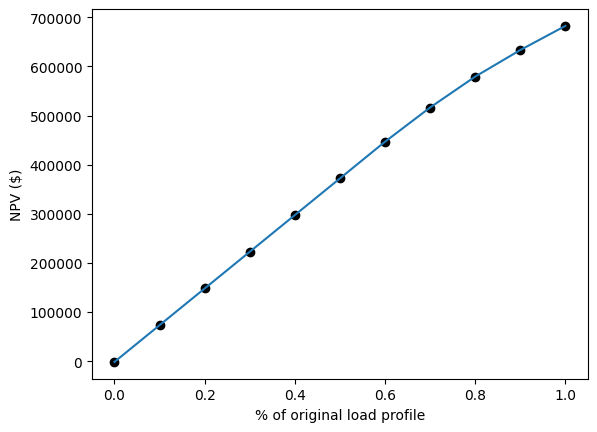

In [32]:
#for loop between 0 and 100 stepping by 10
# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(0.1,1000), (0.1,1000)]

initial_guess = [20, 20]

# cp_sensitivity_npv_vals = []

values = []

# # make a list of carbon prices from 0 to 100 stepping by 10
# carbon_prices = np.arange(0, 100, 10)

reduction_factor = [0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]

for factor in reduction_factor:
    
    a['load_profile'] = load_profile * factor 

    # Optimize
    result = minimize(optimization.objective_function, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

    # Extract the optimal capacity
    optimal_pv_capacity = result.x[0]
    optimal_battery_capacity = result.x[1]
    
    max_npv = result.fun 
    
    values.append(-max_npv)

plt.plot(reduction_factor, values)
plt.xlabel("% of original load profile")
plt.ylabel("NPV ($)")
#put a dot on each point 
plt.scatter(reduction_factor, values, color = 'black')
plt.savefig("figures/ev_load_sensitivity.png")
plt.show()

In [37]:
# Capital Cost of Investment 
pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * optimal_pv_capacity   # (int) capital cost of PV system 
battery_capital_cost = a['battery_cost_per_kWh'] * optimal_battery_capacity  # (int) capital cost of battery
total_capital_cost = pv_capital_cost + battery_capital_cost

# Residual value
residual_value = a['residual_value_factor'] * total_capital_cost

# Generate PV Output profile 
pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], a['annual_insolation_profile'], a['pv_efficiency'], a['renewables_ninja'], optimal_pv_capacity) 

# Generate load shedding schedule 
loadshedding_schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'])

# Generate PV output profile with battery
pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, optimal_battery_capacity, a['battery_duration'],
                                                                        a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
# Net charging load profile 
net_load_profile = a['load_profile'] - pv_with_battery_output_profile
load_profile.sum(), net_load_profile.sum()

TypeError: generate_loadshedding_schedule() missing 1 required positional argument: 'loadshedding_probability'

### Experimenting

Loadshedding penalty

In [ ]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,100), (1,100)]
initial_guess = [20, 20]

# Max land area constraint 
constraint = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Avoid load shedding constraint - net load affected by loadshedding must equal 0
#constraint = {'type': 'eq', 'fun': lambda x: optimization.avoid_loadshedding(x,a)}


# Optimize
result = minimize(optimization.objective_function_with_loadshedding_penalty, x0 = initial_guess, args = (a,), constraints = constraint, bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery capacity: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

### <font color = 'lightblue'> Investigating business models </font>
1. Loan 
2. PAYS
3. PPA 
4. PPA / FIT


Loan

In [39]:
a['loadshedding_probability']

0.43105022831050227

In [331]:
reload(generate_data)
reload(economic_analysis)
reload(optimization)

# Constrain PV and Battery Capacities to be between 1 and 100 kW and kWh respectively
bounds = [(1,1000), (1,1000)]
initial_guess = [20, 20]

# Optimize
result = minimize(optimization.objective_function_for_loan, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Maximum NPV: ${:.2f}".format(-max_npv))

# Constraint value
# constraint_value = constraint['fun'](result.x, a)
# print("Constraint value: {:.2f}".format(constraint_value))

KeyError: 'additional_pv_capital_cost'

PAYS (I think this pretty much works? However it is yielding boundary condition battery. Think about why... Might need to play around with the input assumptions to get something)

In [ ]:
reload(optimization)
reload(generate_data)
reload(economic_analysis)
# pays_capital_adjustment = 0.80 # 30% of capital cost paid upfront
# #pays_payback_period = 10 # 10 years for the solar PV system provider to fully recoup their costs
# #pays_annual_interest_rate = 0.05 # 5% annual interest rate
# pays_cut_of_savings = 0.50 # 50% of savings go to the solar PV system provider


# Constrain PV and Battery Capacities between min and max values
bounds = [(1,1000), (1,1000)]
initial_guess = [20, 20]

#Avoid loadshedding constraint
#constraint = {'type': 'ineq', 'fun': lambda x: optimization.avoid_loadshedding(x,a)} # ineq assumes >= 0
a['max_land_area'] = 1890 
# Max land area constraint 
max_land_area_cons = {'type': 'ineq', 'fun': lambda x: a['max_land_area'] - (x[0] * a['pv_m_sq_per_kw'])} # ineq assumes >= 0

# Optimize
result = minimize(optimization.objective_function_PAYS, x0 = initial_guess, args = (a,), bounds=bounds, method='SLSQP')

# Extract the optimal capacity
optimal_pv_capacity = result.x[0]
optimal_battery_capacity = result.x[1]

# Calculate the minimum cash flow
max_npv = result.fun

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Net present value (NPV) : ${:.2f}".format(-max_npv))


Pyswarm attempt

In [ ]:
import pyswarms as ps
import numpy as np
reload(optimization)
%load_ext autoreload
%autoreload 2 
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

num_particles = 50
num_iterations = 100

# Constrain PV and Battery Capacities between min and max values
lower_bound = 1
upper_bound = 1000
bounds = [(lower_bound,upper_bound), (lower_bound,upper_bound)]

# Initialize swarm with random positions within the search space 
initial_positions = np.random.uniform(lower_bound, upper_bound, (num_particles, 2))


# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions = 2, options=options, bounds=bounds)

# Perform the optimization
best_position, best_fitness = optimizer.optimize(optimization.objective_function_PAYS_PSO, iters=num_iterations,  a = a)

# Print the optimal parameters
print("Optimal PV rating: {:.2f} kW".format(best_position[0]))
print("Optimal battery rating: {:.2f} kWh".format(best_position[1]))

In [ ]:
from deap import base, creator, tools, algorithms
import random


# Define the bounds of the search space
lower_bound = [1, 1]
upper_bound = [100, 100]
bounds = zip(lower_bound, upper_bound)

# Set the parameters for the genetic algorithm
population_size = 50
num_generations = 100

# Create the fitness and individual classes using the DEAP library
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, 1, 100)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attribute)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evaluate(individual):
    return (optimization.objective_function_PAYS(individual, a),)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Generate the initial population
population = toolbox.population(n=population_size)

# Perform the optimization using the genetic algorithm
result, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)

# Extract the best individual from the optimization
best_individual = tools.selBest(result, k=1)[0]

# Extract the optimal capacity
optimal_pv_capacity, optimal_battery_capacity = best_individual

# Calculate the minimum cash flow
max_npv = -best_individual.fitness.values[0]

# Print the results
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Net present value (NPV): ${:.2f}".format(max_npv))


## Checking battery simulation

In [ ]:
import battery_simulation
reload(battery_simulation)

# Define the battery parameters
battery_capacity = 20 # kWh
battery_power = 5 # kW
battery_efficiency = 0.90 # 90% round-trip efficiency
battery_degradation = 0.001 # 0.1% capacity degradation per cycle


### Enumerative method [checking results]

In [ ]:
# set up a matrix length 100 x 100
npv_matrix = np.zeros((100,100))

npvs = []
pv_sizes = []
battery_sizes = []
# keep track of amount of time 

import time 
start_time = time.time()
for pv_capacity in range(1, 100):
    for battery_capacity in range(1, 100):
        # Decision variables - PV capacity and Battery capacity\
        pv_sizes.append(pv_capacity)
        battery_sizes.append(battery_capacity)

        # Capital Cost of Investment 
        pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** a['pv_cost_exponent']    # (int) capital cost of PV system 
        battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity ** a['battery_cost_exponent']   # (int) capital cost of battery
        total_capital_cost = pv_capital_cost + battery_capital_cost

        #### PAYS Business Model ####
        upfront_payment = a['PAYS_capital_cost_adjustment'] * total_capital_cost # (int) upfront payment for panels
        residual_cost_of_panels_owed = total_capital_cost - upfront_payment # (int) residual cost of panels owed

        # Generate PV Output profile 
        pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) 

        # Generate load shedding schedule 
        loadshedding_schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'])

        # Generate PV output profile with battery
        pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                                a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
        # Net charging load profile 
        net_load_profile = a['load_profile'] - pv_with_battery_output_profile

        # Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
        gross_load_affected_by_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

        # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
        saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]

        # Profile of kWh that would be lost to load shedding WITH solar and battery
        net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

        # Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
        gross_load_minus_loadshedding = a['load_profile'] - gross_load_affected_by_loadshedding
        net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 

        # Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
        value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                                a['time_passenger_per_kWh'], a['time_periods'])

        # Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
        energy_cost_without_pv, energy_cost_with_pv = economic_analysis.get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                                a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])

        ##### Monetary savings (revenue) from solar + battery #######

        # Carbon
        carbon_savings_per_year = economic_analysis.get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])

        # Energy  
        energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 

        # Operational
        operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers

        # Total 
        #cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]
            # Payback
        PAYS_payback_per_period = energy_savings_per_year * a['PAYS_cut_of_savings']

        # Revenues TODO: In future versions these will need to be calculated separately for each period, for now assume constant in all periods
        revenues = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(Rproj)]

        # Costs
        payback_per_period = max(PAYS_payback_per_period, residual_cost_of_panels_owed/Rproj)

        if payback_per_period == residual_cost_of_panels_owed/Rproj:
            num_periods = Rproj
        else: 
            num_periods = 0
            paid_back = 0
            while paid_back < residual_cost_of_panels_owed:
                paid_back += payback_per_period
                num_periods += 1 
            
        costs = np.zeros(len(revenues))

        # Fill the first num_periods elements of costs with PAYS_payback_per_period
        costs[:num_periods] = payback_per_period

        # Adjust the last filled element of cost so that the sum of costs is equal to residual_cost_of_panels_owed
        costs[num_periods - 1] = costs[num_periods - 1] + (residual_cost_of_panels_owed - sum(costs[:num_periods]))
            
        cash_flows = [revenue - cost for revenue,cost in zip(revenues,costs)]

        values = []
        for idx, cash_flow in enumerate(cash_flows):
            this_year_value = cash_flow /(1 + discount_rate)**idx
            values.append(this_year_value)
            
        npv = sum(values) - upfront_payment
        
        npvs.append(npv)
        npv_matrix[pv_capacity][battery_capacity] = npv
        
        # print amount of time elapsed
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > 60:
            print(pv_capacity, battery_capacity)
            start_time = time.time()


In [ ]:
# Plot pv_sizes, battery_sizes, and npvs on a 3D plot, with NPVs on the vertical axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pv_sizes, battery_sizes, npvs, c='r', marker='o')
ax.set_xlabel('PV Size (kW)')
ax.set_ylabel('Battery Size (kWh)')
ax.set_zlabel('NPV ($)')
plt.show()


In [ ]:
# Plot npv_matrix as a 3D surface plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(pv_sizes, battery_sizes, npv_matrix)
ax.set_xlabel('PV Size (kW)')
ax.set_ylabel('Battery Size (kWh)')
ax.set_zlabel('NPV ($)')
plt.show()


In [ ]:
# get index of max npv
max_npv = max(npvs)
max_npv_index = npvs.index(max_npv)
print('Max NPV: ', max_npv_index)

In [ ]:
pv_sizes[639], battery_sizes[639]

In [ ]:
print("Optimal PV rating: {:.2f} kW".format(optimal_pv_capacity))
print("Optimal battery rating: {:.2f} kWh".format(optimal_battery_capacity))
print("Investment cost: ${:.2f}".format(economic_analysis.calculate_capital_investment(optimal_pv_capacity, optimal_battery_capacity, a)))
print("Savings per year from carbon: ${:.2f}".format(carbon_savings_per_year))
print("Savings per year from energy: ${:.2f}".format(energy_savings_per_year))
print("Savings per year from avoided loadshedding kWh [operational savings]: ${:.2f}".format(operational_savings_per_year))
print("Total savings per year: ${:.2f}".format(carbon_savings_per_year + energy_savings_per_year + operational_savings_per_year))
# pay back $energy savings * 50% per year over N years
print("Under PAYS, pay ${:.2f} up front, then pay back ${:.2f} per year over {} years".format(upfront_payment, max(PAYS_payback_per_period, residual_cost_of_panels_owed/Rproj), len(costs)))
print("Net present value (NPV): ${:.2f}".format(npv))

### <font color = 'lightblue'> Planning for incremental fleet electrification </font>

Goal is to determine how many vehicles can be successfully electrified and run operationally blah blah blah
Ok so how many vehicles can be completely covered by solar + battery...? 
Need to know how big the solar and battery are for that

The optimization problem is to maximize number of vehicles
subject to the constraints of:
budget
land area
no missed loadshedding hours

key assumption is that more vehicles = greater NPV


What is the most amount of energy that would be needed to be covered during load shedding? Make that the minimum battery capacity... ? 
num_vehicles = 20  # Number of EVs in the simulation
charging_power 
max_loadshedding_consecutive_hours

OR num_vehicles * vehicle_battery_size
20 * 7 = 

In [ ]:
schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'], set_random_seed=False)
pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity)
pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                            a['battery_charging_efficiency'], a['battery_discharging_efficiency'])

### Energy 291 homework example with MIP

In [ ]:
# read excel file Data_Handout.xlsx
df = pd.read_excel('Data_Handout.xlsx', sheet_name='Sheet1')

# Create 

# Split the column into multiple columns
df[['Time', 'Time step', 'WIND-A', 'WIND-B', 'WIND-C', 'Price of power']] = df['Time Time step WIND-A WIND-B WIND-C Price of power'].str.split(' ', expand=True)

df.drop('Time Time step WIND-A WIND-B WIND-C Price of power', axis=1, inplace=True)

# Write df to csv
df.to_csv('Data_Handout.csv', index=False)

In [ ]:
import pandas as pd
from pyomo.environ import *

# Read the data from CSV
PowerData = pd.read_csv("Data_Handout.csv")

OutputA = PowerData["WIND-A"]
OutputB = PowerData["WIND-B"]
OutputC = PowerData["WIND-C"]
PowerPrice = PowerData["Price of power"]
Output = (OutputA + OutputB + OutputC) / 6

POWER = ["WIND-A", "WIND-B", "WIND-C"]
nPOWER = len(POWER)

# Set of time steps
TimeStart = 1
TimeEnd = 432
TIME = list(range(TimeStart, TimeEnd))  # Collect time steps into a list
NumTime = len(TIME)  # Number of time steps

StorageLimit = 100  # MWh
Ccap = 250000  # Capital Cost per MWh ($/MWh capacity)
Lc = 3000  # MWh lifetime stored into battery per MWh of capacity
W = 0.0645  # Round trip losses (MWh/MWh Stored)
T = 432
InitialStorage = 0

# Create a Concrete Model
m = ConcreteModel()

####################################
######## Decision variables ########
####################################

m.StoreIn = Var(range(1, NumTime), domain=NonNegativeReals)  # Output from turbines that is stored in battery
m.StoreOut = Var(range(1, NumTime), domain=NonNegativeReals)  # Amount discharged by battery
m.InStorage = Var(range(1, NumTime + 1), domain=NonNegativeReals)  # Amount in battery storage in next period
m.ToSell = Var(range(1, NumTime), domain=NonNegativeReals)  # Amount sold directly to market

######################################
######## Objective Functions #########
######################################
# Maximize Profit = Revenue - Cost = Revenue from Battery + Revenue from Turbines - Capital Degradation
m.profit = Objective(expr=sum(PowerPrice[t - 1] * (m.ToSell[t] + (1 - W) * m.StoreOut[t]) for t in range(1, NumTime)) - (StorageLimit * Ccap * ((sum(m.StoreOut[t] for t in range(1, NumTime))) / StorageLimit) * (1 / Lc)), sense=maximize)

######################################
############# Constraints ############
######################################

# Storage initialization
m.StorageInit = Constraint(expr=m.InStorage[1] == InitialStorage)

# Storage conservation of energy constraint
m.StorageConservation = ConstraintList()
for t in range(1, NumTime):
    m.StorageConservation.add(m.InStorage[t + 1] == m.InStorage[t] + m.StoreIn[t] - m.StoreOut[t])

# Sufficiency constraint (battery availability constraint)
m.BatteryAvailability = ConstraintList()
for t in range(1, NumTime):
    m.BatteryAvailability.add(m.StoreOut[t] <= m.InStorage[t])

# All power must be sold or stored
m.PowerBalance = ConstraintList()
for t in range(1, NumTime):
    m.PowerBalance.add(Output[t - 1] == m.StoreIn[t] + m.ToSell[t])

# Storage size constraint
m.StorageSize = ConstraintList()
for t in range(1, NumTime):
    m.StorageSize.add(m.InStorage[t] <= StorageLimit)

# Solve the optimization problem
solver = SolverFactory('glpk')
solver.solve(m)



In [ ]:
import pandas as pd
from scipy.optimize import linprog

# Read the data from CSV
PowerData = pd.read_csv("Data_Handout.csv")

OutputA = PowerData["WIND-A"]
OutputB = PowerData["WIND-B"]
OutputC = PowerData["WIND-C"]
PowerPrice = PowerData["Price of power"]
Output = (OutputA + OutputB + OutputC) / 6

POWER = ["WIND-A", "WIND-B", "WIND-C"]
nPOWER = len(POWER)

# Set of time steps
TimeStart = 1
TimeEnd = 432
TIME = list(range(TimeStart, TimeEnd + 1))  # Collect time steps into a list
NumTime = len(TIME)  # Number of time steps

StorageLimit = 100  # MWh
Ccap = 250000  # Capital Cost per MWh ($/MWh capacity)
Lc = 3000  # MWh lifetime stored into battery per MWh of capacity
W = 0.0645  # Round trip losses (MWh/MWh Stored)
T = 432
InitialStorage = 0

# Define the objective function coefficients
c = [-PowerPrice[t] * (1 - W) for t in range(NumTime)]

# Define the constraint matrix
A = [
    [1 if t == i else 0 for t in range(NumTime)] for i in range(NumTime)
]  # Storage conservation of energy constraint

b = [0] * NumTime  # Storage conservation of energy constraint

# Add sufficiency constraint (battery availability constraint)
A += [[0 if t == i else 1 if t == i - 1 else 0 for t in range(NumTime)] for i in range(NumTime)]
b += [0] * NumTime

# Add power balance constraint
A += [
    [1 if t == i else 0 for t in range(NumTime)] for i in range(NumTime)
]  # All power must be sold or stored
b += Output.tolist()

# Add storage size constraint
A += [[0 if t == i else -1 if t == i - 1 else 0 for t in range(NumTime)] for i in range(NumTime)]
b += [0] * NumTime

# Set up the bounds on variables
bounds = [(0, None)] * NumTime

# Solve the linear programming problem
result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs", options={"presolve": False})

print(result)


In [ ]:
import pulp as pl
import pandas as pd

PowerData = pd.read_csv("Data_Handout.csv")

OutputA = PowerData["WIND-A"]
OutputB = PowerData["WIND-B"]
OutputC = PowerData["WIND-C"]
PowerPrice = PowerData["Price of power"]
Output = (OutputA + OutputB + OutputC) / 6

POWER = ["WIND-A", "WIND-B", "WIND-C"]
nPOWER = len(POWER)

# Set of time steps
TimeStart = 1
TimeEnd = 432
TIME = list(range(TimeStart, TimeEnd + 1))
NumTime = len(TIME)

StorageLimit = 100  # MWh
Ccap = 250000  # Capital Cost per MWh ($/MWh capacity)
Lc = 3000  # MWh lifetime stored into battery per MWh of capacity
W = 0.0645  # Round trip losses (MWh/MWh Stored)
T = 432
InitialStorage = 0

m = pl.LpProblem()

# Decision variables
StoreIn = {t: pl.LpVariable(f"StoreIn_{t}", lowBound=0) for t in TIME}
StoreOut = {t: pl.LpVariable(f"StoreOut_{t}", lowBound=0) for t in TIME}
InStorage = {t: pl.LpVariable(f"InStorage_{t}", lowBound=0) for t in range(1, NumTime + 1)}
ToSell = {t: pl.LpVariable(f"ToSell_{t}", lowBound=0) for t in TIME}

# Objective function
m += (
    pl.lpSum(
        PowerPrice[t - 1] * (ToSell[t] + (1 - W) * StoreOut[t]) for t in TIME
    )
    - StorageLimit
    * Ccap
    * (pl.lpSum(StoreOut[t] for t in TIME) / StorageLimit)
    * (1 / Lc)
)

# Constraints
m += InStorage[1] == InitialStorage
for t in TIME:
    m += InStorage[t + 1] == InStorage[t] + StoreIn[t] - StoreOut[t]
    m += StoreOut[t] <= InStorage[t]
    m += Output[t - 1] == StoreIn[t] + ToSell[t]
    m += InStorage[t] <= StorageLimit

# Solve the problem
m.solve()


In [ ]:
def minimize_unserved_hours(pv_capacity, battery_capacity, load_shedding_schedule, a):
    pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) 
    pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                            a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile
    unserved_hours = np.array([net_load_profile[i] if net_load_profile[i] < 0 else 0 for i in range(len(net_load_profile))])
    return unserved_hours.sum()

### Plotting sensitivity to loan capital cost adjustment parameters

In [ ]:
vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
reload(optimization)
b,c,d,e,f,g = optimization.plot_sensitivities('loan_upfront_adjustment', vals, bounds, initial_guess, a, optimization.objective_function_for_loan)
h,i,j,k,l,m = optimization.plot_sensitivities('PAYS_capital_cost_adjustment', vals, bounds, initial_guess, a, optimization.objective_function_PAYS)

Check on values of other vars in optimal result

In [ ]:
# Decision variables - PV capacity and Battery capacity 
pv_capacity = result.x[0]
battery_capacity = result.x[1]

# Capital Cost of Investment 
pv_capital_cost =  a['additional_pv_capital_cost'] + a['pv_cost_per_kw'] * pv_capacity ** 1.5   # (int) capital cost of PV system 
battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity  # (int) capital cost of battery
total_capital_cost = pv_capital_cost + battery_capital_cost

#### PAYS Business Model ####
upfront_payment = a['PAYS_capital_cost_adjustment'] * total_capital_cost # (int) upfront payment for panels
residual_cost_of_panels_owed = total_capital_cost - upfront_payment # (int) residual cost of panels owed

# Generate PV Output profile 
pv_output_profile = generate_data.get_pv_output(a['annual_insolation_profile'], a['pv_efficiency'], pv_capacity) 

# Generate load shedding schedule 
loadshedding_schedule = generate_data.generate_loadshedding_schedule(a['loadshedding_probability'])

# Generate PV output profile with battery
pv_with_battery_output_profile = generate_data.simulate_battery_storage(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],
                                                                        a['battery_charging_efficiency'], a['battery_discharging_efficiency'])
# Net charging load profile 
net_load_profile = a['load_profile'] - pv_with_battery_output_profile

# Profile of kWh that would be lost to load shedding WITHOUT  solar and battery 
gross_load_affected_by_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

# Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_affected_by_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]

# Profile of kWh that would be lost to load shedding WITH solar and battery
net_load_affected_by_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

# Find the load profiles that are net of load shedding - this is the load you neeed to charge $ for [in reality you will need an entirely new schedule] 
gross_load_minus_loadshedding = a['load_profile'] - gross_load_affected_by_loadshedding
net_load_minus_loadshedding = net_load_profile - net_load_affected_by_loadshedding 

# Value of kWh saved from loadshedding BY solar + battery!  [makes above not needed?]
value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding(saved_free_kWh, a['cost_per_passenger'],
                                                                                        a['time_passenger_per_kWh'], a['time_periods'])

# Energy costs ($ for kWh charged) (net of load shedding - so this is actually cheaper than without loadshedding, but we account for the value of missed trips elsewhere)
energy_cost_without_pv, energy_cost_with_pv = economic_analysis.get_cost_of_charging(gross_load_minus_loadshedding, net_load_minus_loadshedding,
                        a['time_of_use_tariffs'], a['time_periods'], a['feed_in_tariff'], feed_in_tariff_bool = a['feed_in_tariff_bool'])

##### Monetary savings (revenue) from solar + battery #######

# Carbon
carbon_savings_per_year = economic_analysis.get_value_of_carbon_offsets(gross_load_minus_loadshedding, net_load_minus_loadshedding, a['grid_carbon_intensity'], a['carbon_price'])

# Energy  
energy_savings_per_year = energy_cost_without_pv.sum() - energy_cost_with_pv.sum() # (float) revenue per year from energy savings 


# Operational
operational_savings_per_year = value_of_charging_saved_by_pv_from_loadshedding.sum() # (float) revenue per year from saved passengers

# Total 
#cash_flows = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(a['Rproj'])]

##### Calculate NPV #####
    # Payback
PAYS_payback_per_period = energy_savings_per_year * a['PAYS_cut_of_savings']

# Revenues TODO: In future versions these will need to be calculated separately for each period, for now assume constant in all periods
revenues = [energy_savings_per_year + operational_savings_per_year + carbon_savings_per_year for i in range(Rproj)]

# Costs
payback_per_period = max(PAYS_payback_per_period, residual_cost_of_panels_owed/Rproj)

num_periods = 0
paid_back = 0
while paid_back < residual_cost_of_panels_owed:
    paid_back += payback_per_period
    num_periods += 1 
    
costs = np.zeros(len(revenues))
# Fill the first num_periods elements of costs with PAYS_payback_per_period
costs[:num_periods] = payback_per_period
# Adjust the last filled element of cost so that the sum of costs is equal to residual_cost_of_panels_owed
costs[num_periods - 1] = costs[num_periods - 1] + (residual_cost_of_panels_owed - sum(costs[:num_periods]))

    
cash_flows = [revenue - cost for revenue,cost in zip(revenues,costs)]

values = []
for idx, cash_flow in enumerate(cash_flows):
    this_year_value = cash_flow /(1 + discount_rate)**idx
    values.append(this_year_value)
    
npv = sum(values) - upfront_payment

npv

In [ ]:
not_covered_kWh = [net_load_profile[i] for i, is_shedding in enumerate(loadshedding_schedule) if is_shedding and net_load_profile[i] > 0]


### Playing with battery optimization models

In [ ]:
import battery_optimization
reload(battery_optimization)

battery_optimization.optimize_battery_energy_flow(a['load_profile'], pv_output_profile, battery_capacity, a['battery_duration'],)

### Todo:
0. Include feed in tariff in the ones with the battery?
0. <font color = 'orange'> Adjust the battery model to prioritize discharge during non-loadshedding hours (we can probably actually optimize the discharge profile since it is known - i.e. optimize it to minimize load shedding hours, or optimize it to minimize total expected cost (including the cost of loadshedding hours)) </font> - <font color = 'lightblue'> Meeting with Becky to discuss </font>
0. <font color = 'lightgreen'> Include capacity (kW) in the battery optimization (speed at which the battery can charge) </font>
2. Include power system gains (voltage stability, reliability?) evaluation, then include that in the objective function somehow... 
    1. include reliability in obj fun?
4. HEADLINE: Numbers or Model???
5. More considerations for optimziation model: Enhance resilience, reduce peak load, reduce loadshedding
    1. Penalty cost for buying during peak hours, penalty cost for resilience violations


1. <font color = 'red'> Options wiht loadshedding: 
    1. Simply evaluate the effect of loadshedding on operations (cost, etc.). Apply a generated loadshedding schedule (assign probability of loadshedding to each hour) to an EV load demand profile, and see how it would shift it if the EV charging operator was blind to the loadshedding before it happened (i.e. they only were able to repsond by charging when power is available).
    2. Optimize the battery storage around predicted loadshedding? 
    3. Use the EVs as storage devices as well (in tandem with the battery - could do this with Brendan)

If model, then I need to probably incldue some shit about loadshedding

IF numbers, then I need really really good dataset and the model needs to be highly accuraet